In [1]:
#from chembl_webresource_client.new_client import new_client
import matplotlib
import pandas as pd
#import modin.pandas as pd
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import EMNN.gnn

import EMNN.gnn.emn_implementations
from EMNN.losses import LOSS_FUNCTIONS
from EMNN.train_logging import LOG_FUNCTIONS
from EMNN.gnn.molgraph_data import MolGraphDataset, molgraph_collate_fn
from EMNN.train_logging import feed_net
from EMNN.train_logging import compute_mse
import datetime

In [2]:
drug_c = pd.read_csv("drugCentral.csv")
endogenous = pd.read_csv("endogenous.csv")
in_trails = pd.read_csv("in-trials.csv")
world = pd.read_csv("world.csv")
df1 = pd.read_csv('Bioactivities2.csv',sep='\t',low_memory=False)

In [3]:
# uniprot_id = "O15648"
# records = new_client.target.filter(target_components__accession=uniprot_id)
# print([(x['target_chembl_id'], x['pref_name']) for x in records])

In [4]:
# chembl_id = "CHEMBL5686"
# records = new_client.activity.filter(target_chembl_id=chembl_id)
# len(records)

In [5]:
# Bio = records[0:7870]

In [6]:
# df= pd.DataFrame(list(Bio.all()))

In [7]:
# pd.DataFrame(df).to_csv("Bioactivities.csv", index=True, sep='\t')

In [8]:
data = pd.read_csv("Bioactivities.csv",sep='\t')

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64726 entries, 0 to 64725
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  64726 non-null  int64  
 1   Molecule ChEMBL ID          64726 non-null  object 
 2   Molecule Max Phase          64726 non-null  int64  
 3   Molecular Weight            64726 non-null  float64
 4   #RO5 Violations             64726 non-null  object 
 5   AlogP                       64726 non-null  object 
 6   Compound Key                64726 non-null  object 
 7   Smiles                      64726 non-null  object 
 8   Standard Type               64726 non-null  object 
 9   Standard Relation           64726 non-null  object 
 10  Standard Value              64726 non-null  float64
 11  Standard Units              64726 non-null  object 
 12  Uo Units                    64726 non-null  object 
 13  Potential Duplicate         647

In [10]:
data = data.dropna(subset=['canonical_smiles', 'molecule_chembl_id']).drop_duplicates(subset=['molecule_chembl_id'])

In [11]:
data.type.value_counts()

Potency     5798
Activity      53
INH           36
IC50          10
Ki             3
Ki/Km          1
Name: type, dtype: int64

In [12]:
data.canonical_smiles

0              OC[C@H]1O[C@H](CNC2CCCC2)[C@@H](O)[C@@H]1O
1       OC[C@H]1O[C@H](CNCc2ccc(Cl)cc2Cl)[C@@H](O)[C@@...
2            OC[C@H]1O[C@H](CNC2CCCCCC2)[C@@H](O)[C@@H]1O
3       OC[C@H]1O[C@H](CNCc2ccc(-c3ccccc3)cc2)[C@@H](O...
4        Cc1ccc(CNC[C@H]2O[C@H](CO)[C@@H](O)[C@@H]2O)cc1C
                              ...                        
7846    COc1ccc(CC(=O)Nc2ccc(S(=O)(=O)Nc3cc(C)on3)cc2)...
7857    Cc1cc(NC(=O)c2ccc(NC(=O)Cc3ccc(Cl)c(Cl)c3)cc2)no1
7863     Cc1cc(NC(=O)c2csc(NC(=O)Cc3ccc(Cl)c(Cl)c3)n2)no1
7868    OC[C@H]1O[C@H](CNc2ccc3ccccc3c2)[C@@H](O)[C@@H]1O
7869    OC[C@H]1O[C@H](CNc2ccc(Cl)c(Cl)c2)[C@@H](O)[C@...
Name: canonical_smiles, Length: 5901, dtype: object

In [3]:
data_reduced = df1[['Smiles','logValue']]

In [9]:
data_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64726 entries, 0 to 64725
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Smiles    64726 non-null  object 
 1   logValue  64726 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1011.5+ KB


In [14]:
drop_low_types = data_reduced[(data_reduced['type'] == 'IC50') | (data_reduced['type']== 'Activity') | (data_reduced['type']== 'INH') | (data_reduced['type']== 'Ki')| (data_reduced['type']== 'Ki/Km')].index

In [15]:
data_reduced_PotOnly = data_reduced.drop(drop_low_types)

In [16]:
data_reduced_PotOnly = data_reduced_PotOnly.dropna()

In [17]:
data_reduced_PotOnly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5798 entries, 66 to 6835
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   canonical_smiles  5798 non-null   object 
 1   type              5798 non-null   object 
 2   value             5798 non-null   float64
dtypes: float64(1), object(2)
memory usage: 181.2+ KB


<AxesSubplot:>

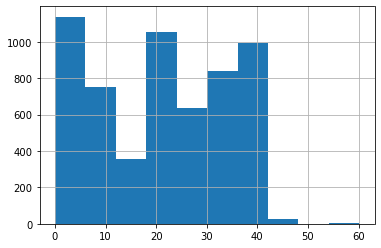

In [18]:
data_reduced_PotOnly['value'].hist()

In [19]:
import numpy as np
data_reduced_PotOnly['logValue'] = -1 * np.log(data_reduced_PotOnly['value'])

In [20]:
# data_prepared = data_reduced_PotOnly.drop(columns = "type")
data_prepared = data_reduced.drop(columns = "value")

In [21]:
data_prepared

,canonical_smiles,logValue
66,Cc1cc(C(=O)NNC(=O)Cc2ccc(Cl)c(Cl)c2)c(C)o1,-3.405564
67,O=C(NC(=S)Nc1ccccc1C(=O)O)c1ccc2ccccc2c1,-2.484532
68,O=C(NCCCN1CCCCCC1)c1ccc(CS(=O)(=O)Cc2ccccc2F)o1,-1.908890
69,NS(=O)(=O)c1ccc(NC(=O)Nc2ccc(C(F)(F)F)cc2)cc1,-2.599655
70,CCNC(=O)C1CCCc2c1[nH]c1ccc(Cl)cc21,-3.060175
...,...,...
6831,C[N+](C)(C)CCO,1.775492
6832,Cc1cc([C@@H]2CCCN2C)on1,-3.981209
6833,Cc1cccc(C2CN(C)CCc3c2cc(O)c(O)c3Cl)c1,0.163461
6834,CC(=O)O[C@H]1CC2(C)[C@@H](C[C@@H](O)[C@H]3[C@@...,-2.024008


In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_prepared['logValue_scaled'] = scaler.fit_transform(data_prepared[['logValue']].values[:,0].reshape(-1, 1))
# df.insert(2, 'value_scaled', scaler.transform(data_prepared[['value']].values[:,0].reshape(-1, 1)), True)

In [4]:
# data_prepared_sacled = data_prepared.drop(columns = "logValue")
# data_prepared_sacled_np = data_prepared_sacled.to_numpy()
data_reduced_np = data_reduced.to_numpy()

In [63]:
import numpy as np
np.random.shuffle(data_reduced_np)
train, valid, test = np.split(data_reduced_np, [int(.76*data_reduced_np.shape[0]), int(.9*data_reduced_np.shape[0])])
train = np.insert(train, 0, [None]*train.shape[0], 1)
valid = np.insert(valid, 0, [None]*valid.shape[0], 1)
test = np.insert(test, 0, [None]*test.shape[0], 1)

In [11]:
import numpy as np


In [64]:
len(train)

49191

In [65]:
len(valid)

9062

In [66]:
len(test)

6473

In [5]:
pd.DataFrame(train).to_csv("Data/leishmaniasis_train.csv.gz", index=False, compression='gzip', sep='\t')
pd.DataFrame(valid).to_csv("Data/leishmaniasis_valid.csv.gz", index=False, compression='gzip', sep='\t')
pd.DataFrame(test).to_csv("Data/leishmaniasis_test.csv.gz", index=False, compression='gzip', sep='\t')

NameError: name 'train' is not defined

In [12]:
train_dataset = MolGraphDataset('Data/leishmaniasis_train.csv.gz')
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=molgraph_collate_fn)
validation_dataset = MolGraphDataset('Data/leishmaniasis_valid.csv.gz')
validation_dataloader = DataLoader(validation_dataset, batch_size=64, collate_fn=molgraph_collate_fn)
test_dataset = MolGraphDataset('Data/leishmaniasis_test.csv.gz')
test_dataloader = DataLoader(test_dataset, batch_size=64, collate_fn=molgraph_collate_fn)

In [13]:
# ((sample_adjacency, sample_nodes, sample_edges), sample_target) = train_dataset[0]

# net = EMNN.gnn.emn_implementations.EMNImplementation(node_features=len(sample_nodes[0]), 
#                                                 edge_features=len(sample_edges[0, 0]), 
#                                                 out_features=len(sample_target), 
#                                                 message_passes=5, edge_embedding_size=30, 
#                                                 edge_emb_depth=2, edge_emb_hidden_dim=60, 
#                                                 edge_emb_dropout_p=0.0, att_depth=2, att_hidden_dim=50, 
#                                                 att_dropout_p=0.0, msg_depth=2, msg_hidden_dim=50, 
#                                                 msg_dropout_p=0.0, gather_width=30, gather_att_depth=2, 
#                                                 gather_att_hidden_dim=15, gather_att_dropout_p=0.0, 
#                                                 gather_emb_depth=2, gather_emb_hidden_dim=15, 
#                                                 gather_emb_dropout_p=0.0, out_depth=2, out_hidden_dim=360, 
#                                                 out_dropout_p=0.1, out_layer_shrinkage=0.6)
                                                
# if True:
#     net = net.cuda()

# optimizer = optim.Adam(net.parameters(), lr=1e-4)
# criterion = nn.MSELoss()

In [14]:
((sample_adjacency, sample_nodes, sample_edges), sample_target) = train_dataset[0]

net = EMNN.gnn.emn_implementations.EMNImplementation(node_features=len(sample_nodes[0]), 
                                                edge_features=len(sample_edges[0, 0]), 
                                                out_features=len(sample_target), 
                                                message_passes=8, edge_embedding_size=50, 
                                                edge_emb_depth=2, edge_emb_hidden_dim=150, 
                                                edge_emb_dropout_p=0.0, att_depth=2, att_hidden_dim=85, 
                                                att_dropout_p=0.0, msg_depth=2, msg_hidden_dim=150, 
                                                msg_dropout_p=0.0, gather_width=45, gather_att_depth=2, 
                                                gather_att_hidden_dim=45, gather_att_dropout_p=0.0, 
                                                gather_emb_depth=2, gather_emb_hidden_dim=45, 
                                                gather_emb_dropout_p=0.0, out_depth=2, out_hidden_dim=450, 
                                                out_dropout_p=0.1, out_layer_shrinkage=0.6)
                                                
if True:
    net = net.cuda()

optimizer = optim.Adam(net.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [15]:
SAVEDMODELS_DIR = "EMNN/savedmodels/"
def evaluate_net(net, train_dataloader, validation_dataloader, test_dataloader, criterion):
    global evaluate_called
    global DATETIME_STR
    global best_mean_train_score
    global best_mean_validation_score
    global best_mean_test_score
    global train_subset_loader
    
    if not evaluate_called:
        evaluate_called = True
        best_mean_train_score, best_mean_validation_score, best_mean_test_score = 10, 10, 10
        train_subset_loader = train_dataloader

    train_output, train_loss, train_target = feed_net(net, train_subset_loader, criterion, True)
    validation_output, validation_loss, validation_target = feed_net(net, validation_dataloader, criterion, True)
    test_output, test_loss, test_target = feed_net(net, test_dataloader, criterion, True)

    train_scores = compute_mse(train_output, train_target)
    train_mean_score = np.nanmean(train_scores)
    validation_scores = compute_mse(validation_output, validation_target)
    validation_mean_score = np.nanmean(validation_scores)
    test_scores = compute_mse(test_output, test_target)
    test_mean_score = np.nanmean(test_scores)

    new_best_model_found = validation_mean_score < best_mean_validation_score

    if new_best_model_found:
        best_mean_train_score = train_mean_score
        best_mean_validation_score = validation_mean_score
        best_mean_test_score = test_mean_score

        path = SAVEDMODELS_DIR + type(net).__name__ + DATETIME_STR
        torch.save(net, path)

    target_names = train_dataloader.dataset.target_names
    return {  # if made deeper, tensorboardx writing breaks I think
        'loss': {'train': train_loss, 'test': test_loss},
        'mean {}'.format("MSE"):
            {'train': train_mean_score, 'validation': validation_mean_score, 'test': test_mean_score},
        'train {}s'.format("MSE"): {target_names[i]: train_scores[i] for i in range(len(target_names))},
        'test {}s'.format("MSE"): {target_names[i]: test_scores[i] for i in range(len(target_names))},
        'best mean {}'.format("MSE"):
            {'train': best_mean_train_score, 'validation': best_mean_validation_score, 'test': best_mean_test_score}
    }

In [16]:
def less_log(net, train_dataloader, validation_dataloader, test_dataloader, criterion, epoch):
    scalars = evaluate_net(net, train_dataloader, validation_dataloader, test_dataloader, criterion)
    mean_score_key = 'mean {}'.format("MSE")
    print('epoch {}, training mean {}: {}, validation mean {}: {}, testing mean {}: {}'.format(
        epoch + 1,
        "MSE", scalars[mean_score_key]['train'],
        "MSE", scalars[mean_score_key]['validation'],
        "MSE", scalars[mean_score_key]['test'])
    )

In [ ]:
evaluate_called = False
best_mean_train_score, best_mean_validation_score, best_mean_test_score = 10, 10, 10
train_subset_loader = None
DATETIME_STR = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')

for epoch in range(15):
    net.train()
    for i_batch, batch in enumerate(train_dataloader):

        if True:
            batch = [tensor.cuda() for tensor in batch]
        adjacency, nodes, edges, target = batch

        optimizer.zero_grad()
        output = net(adjacency, nodes, edges)
        loss = criterion(output, target)
        loss.backward()
        torch.nn.utils.clip_grad_value_(net.parameters(), 5.0)
        optimizer.step()

    with torch.no_grad():
        net.eval()
        less_log(net, train_dataloader, validation_dataloader, test_dataloader, criterion, epoch)

epoch 1, training mean MSE: 0.5146155953407288, validation mean MSE: 0.5127953290939331, testing mean MSE: 0.5301437973976135
epoch 2, training mean MSE: 0.6003549098968506, validation mean MSE: 0.6008053421974182, testing mean MSE: 0.617516279220581
epoch 3, training mean MSE: 0.610195517539978, validation mean MSE: 0.6104124188423157, testing mean MSE: 0.6281699538230896


In [ ]:
def predict(test_set):
    with torch.no_grad():
        #Change this path to predict using different trained models
        net = torch.load("EMNN/savedmodels/EMNImplementation2020-10-29 16:54:38.320439")
        if True:
            net = net.cuda()
        else:
            net = net.cpu()
        net.eval()

        dataset = MolGraphDataset(test_set, prediction=True)
        dataloader = DataLoader(dataset, batch_size=50, collate_fn=molgraph_collate_fn)

        batch_outputs = []
        for i_batch, batch in enumerate(dataloader):
            if True:
                batch = [tensor.cuda() for tensor in batch]
            adjacency, nodes, edges, target = batch
            batch_output = net(adjacency, nodes, edges)
            batch_outputs.append(batch_output)

        output = torch.cat(batch_outputs).cpu().numpy()
        
        df = pd.read_csv(test_set)
        
        df.insert(1, 'value_scaled', output, True)
        
        return df

In [166]:
drug_c.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 4052 entries, 0 to 4051
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ----------  --------------  ----- 
 0   Unnamed: 0  4052 non-null   int64
 1   SMILES      4052 non-null   object
 2   InChI       4052 non-null   object
 3   InChIKey    4052 non-null   object
 4   ID          4052 non-null   int64
 5   INN         4052 non-null   object
 6   CAS_RN      4050 non-null   object
dtypes: object(5), int64(2)
memory usage: 221.7 KB


In [26]:
in_trails_smiles= in_trails.copy()
drug_c_smiles = drug_c.copy()
endogenous_smiles = endogenous.copy()
world_smiles = world.copy()

In [27]:
in_trails_smiles = in_trails_smiles.drop(columns = "zinc_id")
drug_c_smiles = drug_c_smiles.drop(['InChI', 'INN','Unnamed: 0','ID','CAS_RN','InChIKey'], axis = 1) 
endogenous_smiles = endogenous_smiles.drop(columns = "zinc_id")
world_smiles = world_smiles.drop(columns = "zinc_id")

In [28]:
in_trails_smiles.insert(0, 'empty', [None]*len(in_trails_smiles), True)
drug_c_smiles.insert(0, 'empty', [None]*len(drug_c_smiles), True)
endogenous_smiles.insert(0, 'empty', [None]*len(endogenous_smiles), True)
world_smiles.insert(0, 'empty', [None]*len(world_smiles), True)

In [29]:
in_trails_smiles[["empty","smiles"]].to_csv("Data/in_trails_smiles.csv.gz"
                                            , index=False, compression='gzip', sep='\t')

drug_c_smiles[["empty","SMILES"]].to_csv("Data/drug_c_smiles.csv.gz"
                                            , index=False, compression='gzip', sep='\t')

endogenous_smiles[["empty","smiles"]].to_csv("Data/endogenous_smiles.csv.gz"
                                            , index=False, compression='gzip', sep='\t')

world_smiles[["empty","smiles"]].to_csv("Data/world_smiles.csv.gz"
                                            , index=False, compression='gzip', sep='\t')

In [119]:
predictions_in_trails = predict("Data/in_trails_smiles.csv.gz")
predictions_drug_c = predict("Data/drug_c_smiles.csv.gz")
predictions_endogenous = predict("Data/endogenous_smiles.csv.gz")
predictions_world = predict("Data/world_smiles.csv.gz")

In [120]:
predictions

,empty\tsmiles,value_scaled
0,\tO=P(=O)O,[-0.06922221]
1,\tCOc1cccc2c1[C@@H]1CN(CCCCn3c(O)nc4c(sc5ncc(-...,[-0.0641703]
2,\tCN(C)c1cc(CNCC(C)(C)C)c(O)c2c1C[C@H]1C[C@H]3...,[-0.0037107468]
3,\tCN(C)c1cc(CNCC(C)(C)C)c(O)c2c1C[C@H]1C[C@H]3...,[-0.0037107468]
4,\tCN(C)c1cc(CNCC(C)(C)C)c(O)c2c1C[C@H]1C[C@H]3...,[-0.0037107468]
...,...,...
9795,\tO=C1CC2(CCCC2)CC(=O)N1CCNC[C@H]1COc2ccccc2O1,[0.14398]
9796,\tCCCCCCCCCOc1ccc2[nH]cc(CCN)c2c1,[0.0023374557]
9797,\tCOc1cc2c(cc1OC)[C@@]13CCN4CC5=CCO[C@H]6CC(=O...,[0.09909004]
9798,\tCOc1ccc([C@H]2CNC(=O)C2)cc1OC1CCCC1,[-0.017078549]


In [121]:
predictions.sort_values("value_scaled", ascending=False)

,empty\tsmiles,value_scaled
3612,\tCCCCCCCCCCCCOCCOCCOCCOCCOCCOCCOCCOCCOCCO,[1.0734531]
6675,\tO=S(=O)(O)OC[C@H]1O[C@@H](O[C@@]2(COS(=O)(=O...,[0.95221484]
7543,\tO=S(=O)(O)OC[C@H]1O[C@@H](O[C@]2(COS(=O)(=O)...,[0.95221484]
1570,\tCCCCCCCC/C=C\CCCCCCCC(=O)OCC(COC(=O)CCCCCCC/...,[0.93222225]
6738,\tCCCCCCCC/C=C\CCCCCCCC(=O)OC[C@@H](OC(=O)CCCC...,[0.8744521]
...,...,...
4365,\tOC[C@H](O)[C@H](O)[C@@H](O)[C@H](O)CO,[-0.47302383]
6975,\tOC[C@H](O)[C@H](O)[C@@H](O)[C@@H](O)CO,[-0.47302383]
7277,\tOC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,[-0.47302392]
3673,\tOC[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,[-0.47302392]


In [123]:
best_predicted = predictions[["empty\tsmiles"]].values[:10,0]

In [124]:
best_predicted = [best_predicted[i][1:] for i in range(len(best_predicted))]

In [125]:
best_predicted

['O=P(=O)O',
 'COc1cccc2c1[C@@H]1CN(CCCCn3c(O)nc4c(sc5ncc(-c6ccccc6)nc54)c3=O)C[C@@H]1CO2',
 'CN(C)c1cc(CNCC(C)(C)C)c(O)c2c1C[C@H]1C[C@H]3[C@H](N(C)C)C(=O)[C@H](C(N)=O)C(=O)[C@@]3(O)C(=O)[C@H]1C2=O',
 'CN(C)c1cc(CNCC(C)(C)C)c(O)c2c1C[C@H]1C[C@H]3[C@H](N(C)C)C(=O)[C@@H](C(N)=O)C(=O)[C@@]3(O)C(=O)[C@@H]1C2=O',
 'CN(C)c1cc(CNCC(C)(C)C)c(O)c2c1C[C@H]1C[C@H]3[C@H](N(C)C)C(=O)[C@@H](C(N)=O)C(=O)[C@@]3(O)C(=O)[C@H]1C2=O',
 'Cc1ccc2c(n1)Oc1ccc([C@@H](C)C(=O)OCC(=O)N(C)C)cc1C2',
 'CN(C)c1cc(CNCC(C)(C)C)c(O)c2c1C[C@H]1C[C@H]3[C@H](N(C)C)C(=O)[C@H](C(N)=O)C(=O)[C@@]3(O)C(=O)[C@@H]1C2=O',
 'CCOc1cc(N)c(Cl)cc1C(=O)NC[C@@H]1CN(Cc2ccc(F)cc2)CCO1',
 'CCOc1cc(N)c(Cl)cc1C(=O)NC[C@H]1CN(Cc2ccc(F)cc2)CCO1',
 'CC(=O)C(=Cc1cc(O)c(O)c([N+](=O)[O-])c1)C(C)=O']

In [126]:
import pickle
pickle.dump(best_predicted, open("Data/best_predicted_smiles.pkl", "wb"))

In [127]:
best_predicted = pickle.load(open("Data/best_predicted_smiles.pkl", "rb"))

In [128]:
import rdkit
from rdkit.Chem import AllChem as Chem
from rdkit.DataStructs import cDataStructs
best_predicted_mols = [Chem.MolFromSmiles(x) for x in best_predicted]

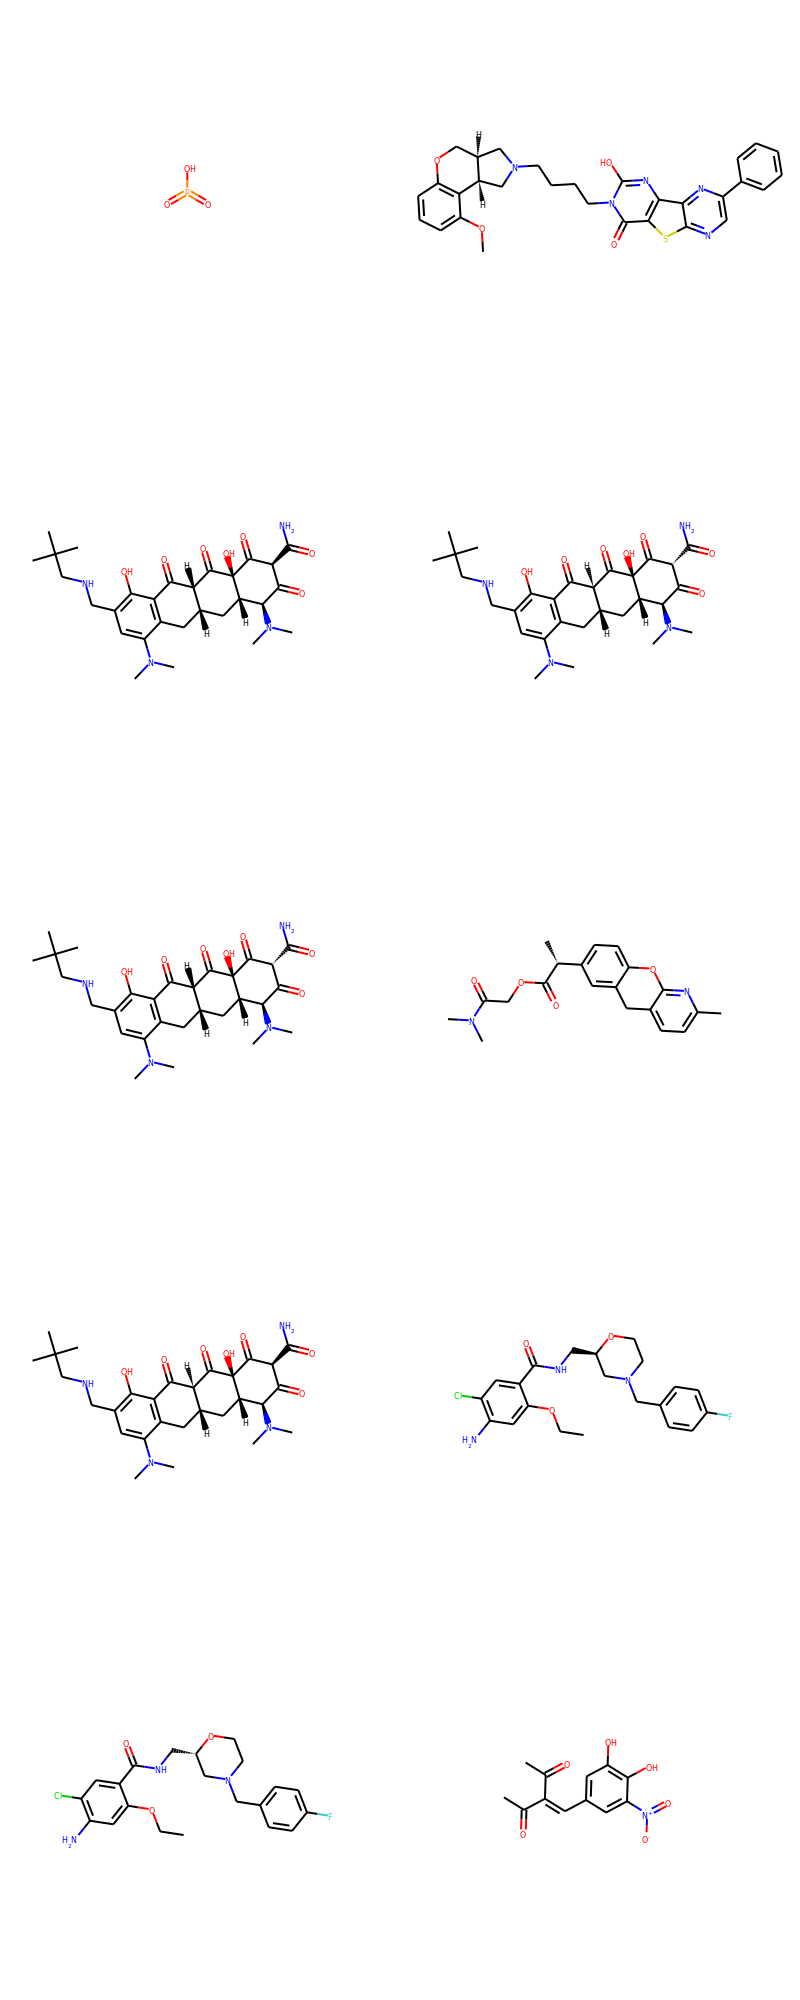

In [129]:
rdkit.Chem.Draw.MolsToGridImage(best_predicted_mols, molsPerRow=2, maxMols=100, subImgSize=(400, 400))